### 1: Importing Required Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import pylab
#for dickey-fuller test
import statsmodels.tsa.stattools as sts
#to check seasonality in dataset
from statsmodels.tsa.seasonal import seasonal_decompose
#for autocorrelation 
import statsmodels.graphics.tsaplots as sgt
#for estimation of future values
#arima model
from statsmodels.tsa.arima.model import ARIMA
#sarima model 
from statsmodels.tsa.statespace.sarimax import SARIMAX

sns.set()

#for chi square test
from scipy.stats.distributions import chi2


#for model evaluation
from sklearn.metrics import mean_squared_error
#for warnings
import warnings

warnings.filterwarnings("ignore")

Importing Csv File that has Inflation rate in Value Column and Month and Year mentioned in Date column.

In [2]:
df= pd.read_csv('Inflation_rate_processed.csv')

### 2:  Understanding and Transforming Dataset

In [3]:
df.head()

,Unnamed: 0,value,Date
0,0,2.0,1914-01-01
1,1,1.0,1915-01-01
2,2,3.0,1916-01-01
3,3,12.5,1917-01-01
4,4,19.7,1918-01-01


In [4]:
del df['Unnamed: 0']

In [5]:
df.head()

,value,Date
0,2.0,1914-01-01
1,1.0,1915-01-01
2,3.0,1916-01-01
3,12.5,1917-01-01
4,19.7,1918-01-01


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1320 entries, 0 to 1319
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   value   1319 non-null   object
 1   Date    1320 non-null   object
dtypes: object(2)
memory usage: 20.8+ KB


In [7]:
df.describe()

,value,Date
count,1319,1320
unique,234,1320
top,3.0,1914-01-01
freq,37,1


Checking for Null Values:

Converting Data Type of the Date Column:

In [8]:
df.isna().sum()

value    1
Date     0
dtype: int64

**Chaging Data Types of Columns to appropriate Data Type:**

In [9]:
df['Date']= pd.to_datetime(df['Date'])

In [10]:
df['value'] = pd.to_numeric(df['value'], errors='coerce')

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1320 entries, 0 to 1319
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   value   1318 non-null   float64       
 1   Date    1320 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 20.8 KB


In [12]:
df.head()

,value,Date
0,2.0,1914-01-01
1,1.0,1915-01-01
2,3.0,1916-01-01
3,12.5,1917-01-01
4,19.7,1918-01-01


Sorting Data in terms of Date:

In [13]:
df.sort_values(by= 'Date', inplace=True)

In [14]:
df.head()

,value,Date
0,2.0,1914-01-01
110,1.0,1914-02-01
220,1.0,1914-03-01
330,0.0,1914-04-01
440,2.1,1914-05-01


**Setting the date as Index:**
We have to set our index to date so that We can make it time series as every value will refer to a date instead of an integer index.

In [15]:
df.set_index('Date', inplace= True)

In [16]:
df.head()

,value
Date,
1914-01-01,2.0
1914-02-01,1.0
1914-03-01,1.0
1914-04-01,0.0
1914-05-01,2.1


**Now this Data Frame has Become Time Series.**

### Plotting the Data for OverView:

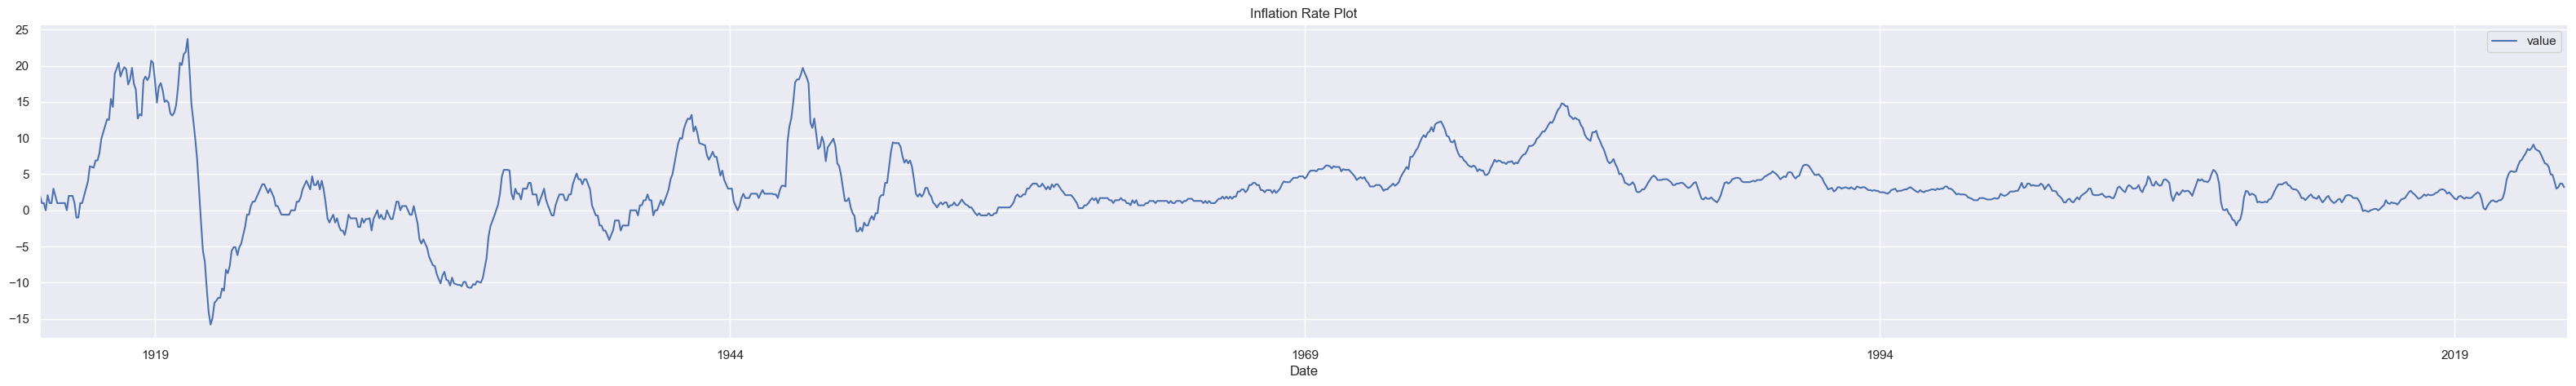

In [17]:
df.plot(figsize= (40,5), title= 'Inflation Rate Plot')
plt.show() 


**A Closer Look:**

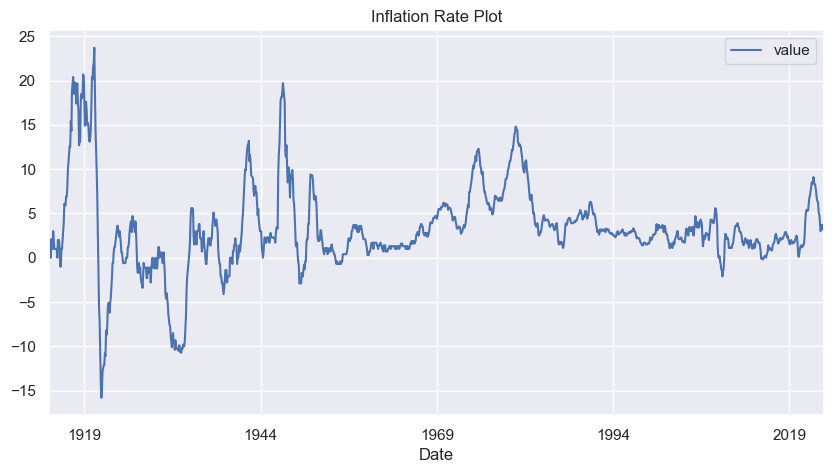

In [18]:
df.plot(figsize= (10,5), title= 'Inflation Rate Plot')
plt.show() 

### 3: Time Series Analysis

**QQ Plot:**

Quantile-Quantile Plot is used to determine whether a dataset is distributed in a certain way.Usually show how data fits to Normal Distribution.

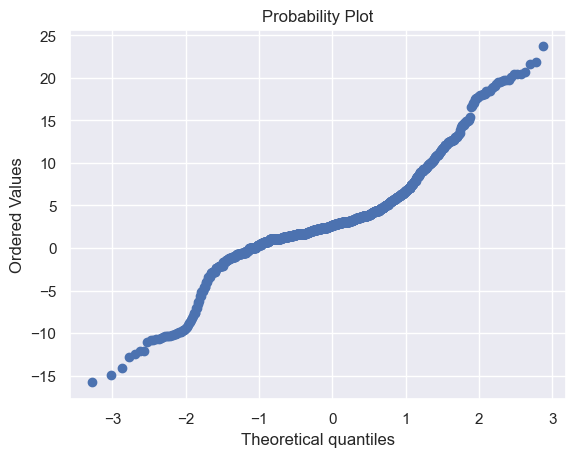

In [19]:
#we will use probplot
#first arg will be of series we want to check 
#second arg will show how we want to express plot
scipy.stats.probplot(df['value'], plot= pylab)
pylab.show()

**Now Checking for Null Values:**

In [20]:
df.isna().sum()

value    2
dtype: int64

In [21]:
#filling null values with forward fill: Assign the value of Previous period (data point)
df.fillna(method= 'ffill',inplace= True)
df.isna().sum()

value    0
dtype: int64

#### Dickey-Fuller Test:

Basically Dickey Fuller test is done to check if the data fill-full the Covariance Stationarity or not.

**Co-variance Stationarity:** It says if we have equal number of data points in different intervals like if we have data points **a1, a2, a3, a4, a5, a6, a7, a8** and we choose **a2, a3, a4** and **a3, a4, a5** then the Covariance (that means relation between two) will be same.Also **Mean of data points will be 0** and **Variance will be Constant** (that mean spread between datapoints will be same).

**Null Hypothesis of Dickey-Fuller Test:** Non stationarity (data does not fill-full assumptions of Stationarity).
If test statistics < critical value from dickey-fuller table then we reject the Null hypothesis and accept **Alternate Hypothesis** which says that data comes from stationer process.


In [22]:
#applying dickey-fuller test on inflation rate
sts.adfuller(df.value)

(-5.854904962695085,
 3.518656779158127e-07,
 16,
 1303,
 {'1%': -3.435378572037035,
  '5%': -2.863760700696655,
  '10%': -2.56795231450063},
 2521.2183591469675)

**First Value = -5.854904962695085** ===> We get the Test Statistics (this value will be compared with Critical Value and if -5.854904962695085<Critical value then we reject null hypothis and data will stationer)
    
    
**Second Value = 3.518656779158127e-07** ===> Show the p-value that means--> % chance to not reject the Null Hyposthis which overall means that there are - % chances that Time Series does comes from Covariance Stationer Process.
    
**Third Value = 16** ===> Autocorrelation go back to 16 periods (We will consider it while picking up model)
    
**Fourth Value = 1303** ===> Number of observations used in the Analysis.

**{'1%': -3.435378572037035,
  '5%': -2.863760700696655,
  '10%': -2.56795231450063}** ====>Shows the 1, 5 and 10 % confidence level critical values from dickey fuller table so that we can compare them with Testing statistics or first value.
      
                            As -5.854904962695085 is SMALLER than any value in 
                            different values of level of significance that                                
                            means We will reject the Null Hypothesis and 
                            Inflation rate time series does show Covariance 
                            Stationarity.
         
         
**Last value = 2521.2183591469675** ===> Shows there is some apparent autocorrelation, Lower the value it is easier to predict values in future.

#### Seasonality:

Seasonality in dataset means that Trend appears in Cyclical Basics.

    For Example: Temperature depends on Time of day and Months of the Year.
We can perform decomposition on time series to test if there is Seasonality in the dataset or not.
    
    We decompose time series into Trend(Pattern followed), Seaonal (Cyclic effect) and Residual Effect (error).
Then We can use Naive Additive or Naive Multiplicative decomposition to check for seasonality.

    1. In Naive Additive we say that original series is addition of Trend, Seasonal, and Residual Effect.
    2. In multiplicative we say that original series is multiplication fo Trend, Seasonal, and Residual Effect.
    

**Additive Seasonality:**

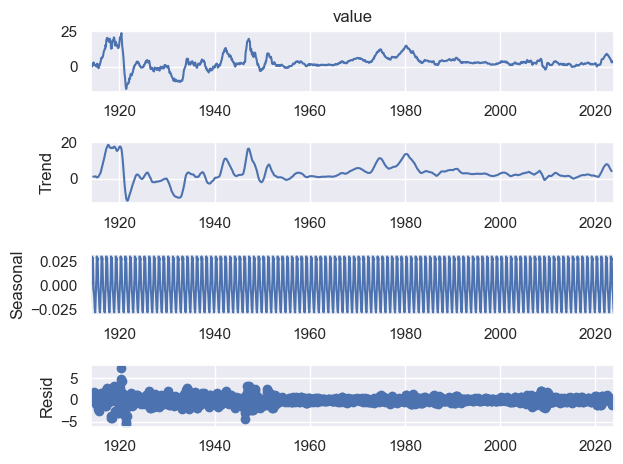

In [23]:
seasonal_decomposition_additive= seasonal_decompose(df.value, model= 'additive')
#plotting
seasonal_decomposition_additive.plot()
plt.show()

**Insights from Graph:**

    - Value plot is plot of Data points over the time period.
    - Resid shows properly points that are deviated from pattern.
    

#### Auto-Correlation Factor:
AutoCorrelation means how current data is correlated or resemble with previous data of same time series.

    Time Series where data points are autocorrelated mean current is similar to previous, it is known as lagged time series.
    It is known as lagged because current data is just delayed version of previous data point.
    
Lets Check if there is any Auto-Correlation in my Time series:

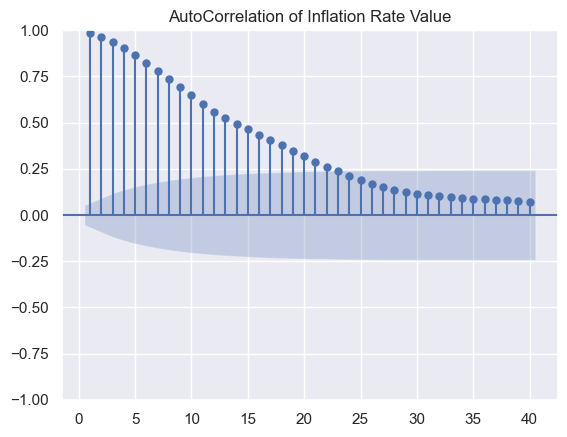

In [24]:
#to find autocorrelation in the time series, we will use tsaplot package of graphics

#Basically in default it will check all previous points relation with current
#but we can change through lag arguement

#common practice is to analyze first 40 lags-->that mean last 40 data points(or data of last 40 periods than our current)

#zero= False means we do not want to add correlation of same values becuase it will be always 1
sgt.plot_acf(df.value, lags= 40, zero= False)

plt.title('AutoCorrelation of Inflation Rate Value')
plt.show()

        x-axis represnt lags(previous points) as they are 40 that were specified by us.
        y-axis represent values of autocorrelation.
        
      First line on left which is 1 shows the Autocorrelation of a(t) data point with a(t-1) means 1 period back and so on.
      
      The blue are on x-axis show Significance, Values that are situated outside this blue area shows that they are significantly different from zero and they are autocorrelated.


#### Partial AutoCorrelation:
So If we want to find direct effect of any previous data point on current (relation  between them) we use Partial Autocorrelation.
            
            For Example:
                a1, a2, a3, a4, a5
       We want to find AutoCorrelation between a1 and a5 so this direct version can be found with Parital Autocorrelation.
                       

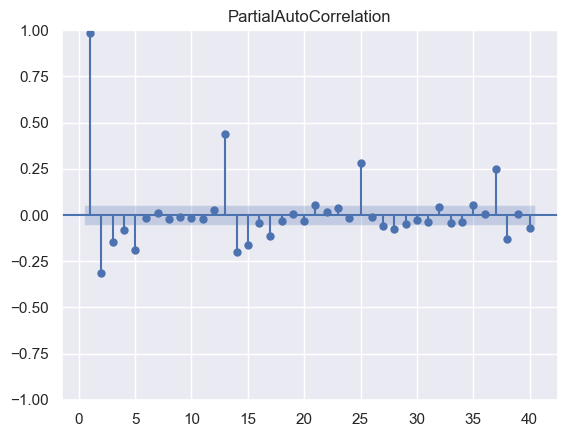

In [25]:
#ols is one of method of finding partical auto corr
sgt.plot_pacf(df.value, lags= 40, zero= False, method=('ols'))
plt.title('PartialAutoCorrelation')
plt.show()

As you can see it has change alot than autocorrelation because, In auto correlation we were seeing effect like:
                
                if data points are:
                         d1, d2, d3, d4, d5
                         In Autocorrelation: we were seeing affect of d2 on d5 like:
                                 d2--->d3--->d4--->d5
                                 (Like we have enter connected data points in middle)
                                 
                         But in Partial AutoCorrelation:
                                  d2--->d5
                                  (We see direct affect of d2 on d5)
                 Thats why everything has changed alot.

#### Splitting the Dataset for Forecasting:
Just like what we do in Machine Learning for training model, we split the data into training and testing. But in Standard Machine Learning we split the data randomly, but in Timer Series we have to maintain the chronological order of Time Series.

        So what we will do is to split on specific Time Period and Data Points before that Time Period will be Training Data Points and after that will be Testing Data Points.

In [26]:
#our training dataset size will be 60 % and testing dataset size will be 20%
#to get a point unitl 60%
training_size= int(len(df) * 0.6)

In [27]:
#now using that point
#tarining dataset
df_train= df.iloc[:training_size]

#testing dataset
df_test= df.iloc[training_size:]

To Confirm Connection:

In [28]:
df_train.tail()

,value
Date,
1979-08-01,11.8
1979-09-01,12.2
1979-10-01,12.1
1979-11-01,12.6
1979-12-01,13.3


In [29]:
df_test.head()

,value
Date,
1980-01-01,13.9
1980-02-01,14.2
1980-03-01,14.8
1980-04-01,14.7
1980-05-01,14.4


### 4: Time Series Forecasting

### 1. ARIMA Model:
            -AutoRegressor Integrated Moving Average Model

**How to decide p, q, d in Order Parameter:**
        
        --p: Plot ACF of dataset and select p where in ACF there is first most significant point. Like in ACF of our dataset most correlated(significant (highest peak)) is at 1.
        
        --q: Plot PACF of dataset and select q where in PACF there is first most significant point. In our dataset highest significant is at 13.
        
        --As our data is stationer means no difference so d=0

In [136]:
ar_model= ARIMA(df_train.value, order= (13,0,11))

In [137]:
ar_results= ar_model.fit()

In [138]:
ar_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  792
Model:               ARIMA(13, 0, 11)   Log Likelihood                -825.177
Date:                Thu, 23 Nov 2023   AIC                           1702.354
Time:                        16:22:42   BIC                           1823.892
Sample:                    01-01-1914   HQIC                          1749.065
                         - 12-01-1979                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.2472      1.744      1.862      0.063      -0.172       6.666
ar.L1          0.3282      0.036      9.163      0.000       0.258       0.398
ar.L2          0.0985      0.037      2.666      0.008       0.026       0.171
ar.L3          0.0650      0.031      2.114      0.035       0.005       0.125
ar.L4          0.2314      0.037      6.222      0.000       0.158       0.304
ar.L5          0.0042      0.035      0.120      0.905      -0.064       0.072
ar.L6         -0.0364      0.037     -0.987      0.324      -0.109       0.036
ar.L7         -0.0198      0.034     -0.588      0.556      -0.086       0.046
ar.L8          0.0546      0.037      1.471      0.141      -0.018       0.127
ar.L9         -0.0376      0.038     -0.992      0.321      -0.112       0.037
ar.L10         0.0279      0.038      0.731      0.465      -0.047       0.103
ar.L11         0.0746      0.035      2.109      0.035       0.005       0.144
ar.L12        -0.0166      0.033     -0.499      0.618      -0.082       0.049
ar.L13         0.0426      0.034      1.245      0.213      -0.024       0.110
ma.L1          0.9586      0.085     11.250      0.000       0.792       1.126
ma.L2          0.9674      0.130      7.467      0.000       0.713       1.221
ma.L3          0.9524      0.131      7.278      0.000       0.696       1.209
ma.L4          0.9343      0.085     11.013      0.000       0.768       1.101
ma.L5          0.9076      0.026     34.537      0.000       0.856       0.959
ma.L6          0.9192      0.095      9.706      0.000       0.734       1.105
ma.L7          0.9361      0.171      5.464      0.000       0.600       1.272
ma.L8          0.9508      0.215      4.429      0.000       0.530       1.372
ma.L9          0.9807      0.215      4.571      0.000       0.560       1.401
ma.L10         0.9440      0.166      5.698      0.000       0.619       1.269
ma.L11         0.9640      0.093     10.348      0.000       0.781       1.147
sigma2         0.4524      0.042     10.665      0.000       0.369       0.536
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):              3249.09
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               0.12   Skew:                             0.86
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**Forecasting on Test Set**

In [139]:
test_set_forecast = ar_results.forecast(len(df_test))


In [140]:
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(df_test, test_set_forecast)
print(f'Mean Squared Error: {mse}')


Mean Squared Error: 2.86931540207757


In [141]:
import plotly.graph_objects as go

def plot_forecasts(forecasts: list[float], title: str) -> None:
    """Function to plot the forecasts."""
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df_train.index, y=df_train.value, name='Train_set'))
    fig.add_trace(go.Scatter(x=df_test.index, y=df_test.value, name='Test_set'))
    fig.add_trace(go.Scatter(x=df_test.index, y=test_set_forecast, name='Forecast'))
    fig.update_layout(template="simple_white", font=dict(size=18), title_text=title,
                      width=650, title_x=0.5, height=400, xaxis_title='Date',
                      yaxis_title='Inflation Rate')

    return fig.show()


# Plot the forecasts
plot_forecasts(test_set_forecast, 'ARIMA')

### 2. SARIMA Model:

In [142]:
# Defining the order and seasonal_order parameters
#the order will be according to what we choosen in ARIMA
order = (1, 0, 0)  
seasonal_order = (10, 0, 0, 13) 

# Fit the SARIMA model
sarima_model = SARIMAX(df_train['value'], order=order, seasonal_order=seasonal_order)
result = sarima_model.fit(disp=False)


                                      SARIMAX Results                                      
Dep. Variable:                               value   No. Observations:                  792
Model:             SARIMAX(1, 0, 0)x(10, 0, 0, 13)   Log Likelihood               -1106.144
Date:                             Thu, 23 Nov 2023   AIC                           2236.289
Time:                                     17:09:50   BIC                           2292.384
Sample:                                 01-01-1914   HQIC                          2257.848
                                      - 12-01-1979                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9937      0.003    321.262      0.000       0.988       1.000
ar.S.L13      -0.0778      

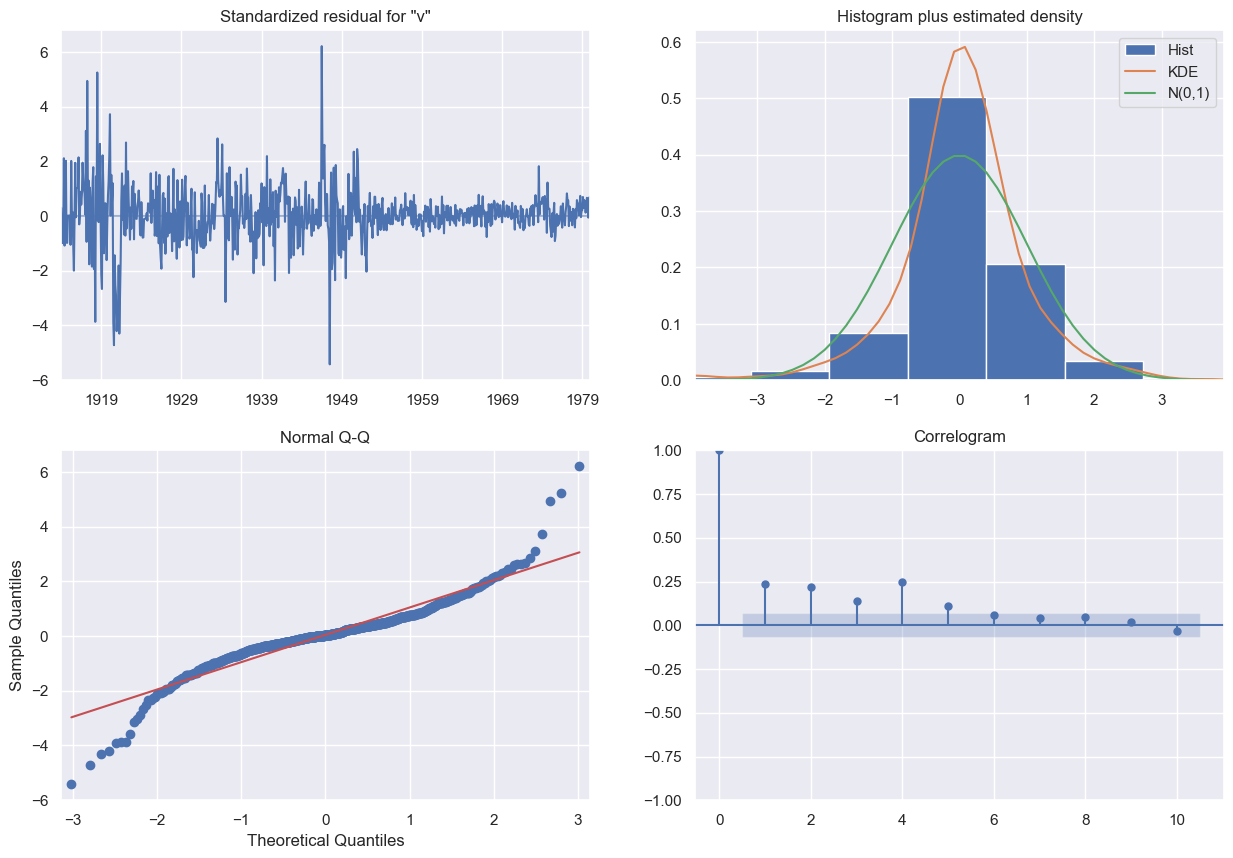

In [143]:
print(result.summary())
result.plot_diagnostics(figsize=(15, 10))
plt.show()


**Forecasting on Test Set:**

In [144]:
sarima_forecast = result.forecast(len(df_test))

In [145]:
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(df_test, sarima_forecast)
print(f'Mean Squared Error: {mse}')


Mean Squared Error: 5.205611761564578


In [146]:
import plotly.graph_objects as go

def plot_forecasts(forecasts: list[float], title: str) -> None:
    """Function to plot the forecasts."""
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df_train.index, y=df_train.value, name='Train_set'))
    fig.add_trace(go.Scatter(x=df_test.index, y=df_test.value, name='Test_set'))
    fig.add_trace(go.Scatter(x=df_test.index, y=sarima_forecast, name='Forecast'))
    fig.update_layout(template="simple_white", font=dict(size=18), title_text=title,
                      width=650, title_x=0.5, height=400, xaxis_title='Date',
                      yaxis_title='Infalation Rate')

    return fig.show()


# Plot the forecasts
plot_forecasts(test_set_forecast, 'SARIMA')

### 3. Forecasting with Facebook Prophet

Making a copy of the main dataframe and fill fulling the requirements of Facebook Prophet.

In [147]:
df_copy = df.copy()

#Making Date Column as required by Facebook Prophet
df_copy.reset_index(inplace=True)

#Renaming Date Column as required by Facebook Prophet
df_copy= df_copy.rename(columns={'Date': 'ds', 'value': 'y'})

#making training and test sets as we did earlier
training_size= int(len(df) * 0.6)
#tarining dataset
df_copy_train= df_copy.iloc[:training_size]

#testing dataset
df_copy_test= df_copy.iloc[training_size:]

In [148]:
df_copy.head()

,ds,y
0,1914-01-01,2.0
1,1914-02-01,1.0
2,1914-03-01,1.0
3,1914-04-01,0.0
4,1914-05-01,2.1


In [149]:
from prophet import Prophet

Making Instance of the Prophet Model:

In [150]:
prophet_model= Prophet()

Fitting model to our data:

In [151]:
prophet_model.fit(df_copy_train)

17:09:54 - cmdstanpy - INFO - Chain [1] start processing
17:09:54 - cmdstanpy - INFO - Chain [1] done processing


**Forecasting with Prophet Model:**

In [152]:
# making dataframe of our test dataset size
future = prophet_model.make_future_dataframe(len(df_copy_test))

In [153]:
forecast = prophet_model.predict(future)

#predictions/forecasting
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1315,1981-05-08,4.628223,-2.209901,10.947326
1316,1981-05-09,4.370960,-2.522451,11.103697
1317,1981-05-10,4.150493,-3.386337,10.550708
1318,1981-05-11,3.971233,-3.226034,10.702934
1319,1981-05-12,3.836570,-3.392192,10.615232


In [154]:
import plotly.graph_objects as go

def plot_forecasts(forecasts: list[float], title: str) -> None:
    """Function to plot the forecasts."""
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df_copy_train.ds, y=df_copy_train.y, name='Train_set'))
    fig.add_trace(go.Scatter(x=df_copy_test.ds, y=df_copy_test.y, name='Test_set'))
    fig.add_trace(go.Scatter(x=df_copy_test.ds, y=forecast['yhat'], name='Forecast'))
    fig.update_layout(template="simple_white", font=dict(size=18), title_text=title,
                      width=650, title_x=0.5, height=400, xaxis_title='Date',
                      yaxis_title='Infalation Rate')

    return fig.show()


# Plot the forecasts
plot_forecasts(forecast, 'Facebook Prophet')

### 4: SMA Model:

In [158]:
# Function to calculate SMA
def calculate_sma(data, window_size):
    return data['value'].rolling(window=window_size).mean()

# Define the window size for SMA
window_size = 3

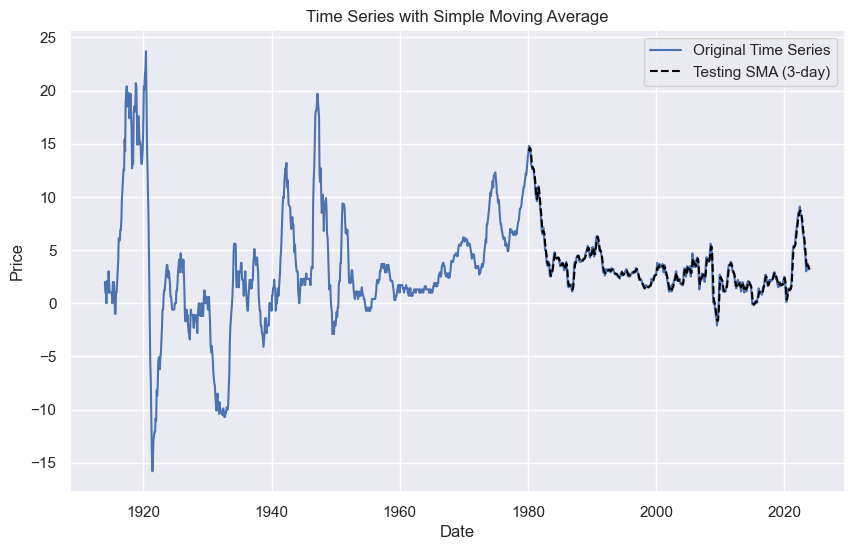

In [165]:
# Calculate SMA and add it to the DataFrame
df_train['SMA_train'] = calculate_sma(df_train, window_size)

#on the test set
df_test['SMA_test'] = calculate_sma(df_test, window_size)
# Plot the original time series and the SMA
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['value'], label='Original Time Series')
plt.plot(df_test.index, df_test['SMA_test'],  label=f'Testing SMA ({window_size}-day)', linestyle='--', color='black')
plt.title('Time Series with Simple Moving Average')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [170]:
df_test['value'].isna().sum()

0

In [166]:
# Calculate Mean Squared Error (MSE)
mse_sma = mean_squared_error(df_test['value'], df_test['SMA_test'])
print(f'Mean Squared Error: {mse}')



ValueError: Input contains NaN, infinity or a value too large for dtype('float64').